In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import dask.dataframe as dd
import pandas as pd
import seaborn as sns

In [3]:
pd.set_option("max_rows", 100)
pd.set_option("max_colwidth", 2000)

In [4]:
df = pd.read_csv("./data/Corona_NLP_train.csv")
df_test = pd.read_csv("./data/Corona_NLP_test.csv")
#df = dd.from_pandas(df, npartitions=1)
#df = df.persist()

# Data Exploration
Let's begin with examining a few datapoints and attributes.

In [5]:
df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative


In [6]:
set(df.Sentiment)

{'Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'}

There are some immediate observations about the tweets: 

Obviously there are hashstags, which are concatenations of words, which might not be able to be tokenized easily. Hashtags could, however be extracted as a separate feature.

Some tweets contain URL, which might not be easily processed within standard NLP pipelines.

Some tweets contain tab and newline characters ('\n' or '\r').

The location attributes seems not to correspond to physical information in a lot of cases. If this attribute was to be used, there would be a need for complex data cleaning.

In [7]:
set(df.Location)

{nan,
 'Inghilterra, Regno Unito',
 'Solihull UK',
 'Cocklake, England',
 'Totton, England',
 'Southwest, Florida',
 'Disabled (with too many chromosomes) disease-ridden chronic illness & surgery survivor. Vegetarian resides MEL Disclaimer: RTs?endorsement!',
 'Lawrenceville, GA',
 "Shanghai, People's Republic of",
 'London and online ',
 'c?????g??? ',
 'Londinium ',
 'Mars, Space',
 'Manchester, Europe',
 '#SubGenius of Florida',
 'Salalah, Oman',
 'Derby ish ',
 'CO Rockies... approx 7000 ft.',
 'Boise, Idaho',
 'Simcoe County',
 'South Africa, Cape Town ',
 'Maryland',
 'Dallas TX and East Texas',
 'Lakhimpur Kheri',
 'Muscle Shoals, AL',
 'Southwestern Ontario',
 'Haarlem',
 'East Lothian',
 'Methuen Town, MA',
 'Bicester, England',
 'International Potato Center',
 'Buckhurst hill / London',
 '#CampSupernatural England',
 'The American Riviera',
 '?????? ',
 'The6',
 'Ferrara, Emilia Romagna',
 'Uni of Gloucestershire',
 'los angeles ca',
 'Praia, Cabo Verde',
 'Content is not adv

Furthermore, the location is missing in an approximate 20% of datapoints

In [8]:
df.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

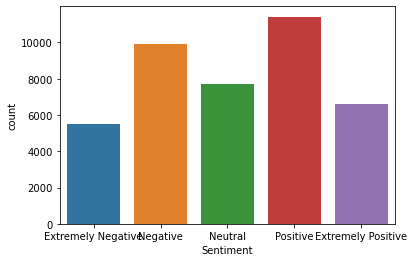

In [9]:
sns.countplot(data=df, x="Sentiment", order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])

# Data Cleaning
Next let's identify potentially problematic patterns using regex.

In [10]:
clean_df = df.copy()

Clean up whitespace.

In [11]:
clean_df['OriginalTweet'] = clean_df['OriginalTweet'].str.replace('[\n\r]', ' ', regex=True)
clean_df['OriginalTweet'] = clean_df['OriginalTweet'].str.replace(' +', ' ', regex=True)

Remove repeated question marks.

In [12]:
clean_df['OriginalTweet'] = clean_df['OriginalTweet'].str.replace('\?+', '?', regex=True)
clean_df['OriginalTweet'] = clean_df['OriginalTweet'].str.replace('(?:\? ?)+', '?', regex=True)

Remove URLs.

In [13]:
clean_df['OriginalTweet'] = clean_df['OriginalTweet'].str.replace('http[^ ]*', ' ', regex=True)

Change ampercent sign and the xml entity to "and" word.

In [14]:
clean_df['OriginalTweet'] = clean_df['OriginalTweet'].str.replace('(&amp;)|&', 'and', regex=True)

Change hashtags to normal words (remove the '#').

'#yolo' -> 'yolo'

In [15]:
clean_df['OriginalTweet'] = clean_df['OriginalTweet'].str.replace('#', ' ', regex=True)

Remove reference to twitter Users.

Example: '@bbc'

In [16]:
clean_df['OriginalTweet'] = clean_df['OriginalTweet'].str.replace('@[^ ]+', ' ', regex=True)

remove duplicate whitespaces

In [17]:
clean_df['OriginalTweet'] = clean_df['OriginalTweet'].str.replace(' +', ' ', regex=True)

...and lastly drop tweets, which likely don't contain a word.

In [18]:
clean_df = clean_df[clean_df['OriginalTweet'].str.contains('\w{4,}')]

Change labels to integer format.

In [19]:
set(clean_df['Sentiment'])

{'Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'}

In [20]:
label_dict = {
    'Extremely Negative': 0, 
    'Negative': 0, 
    'Neutral': 1, 
    'Positive': 2,
    'Extremely Positive': 2
}
clean_df['SentimentCode'] = clean_df['Sentiment'].replace(label_dict)
clean_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,SentimentCode
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive,2
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak",Positive,2
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty... PLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. Stay calm, stay safe. COVID19france COVID_19 COVID19 coronavirus confinement Confinementotal ConfinementGeneral",Positive,2
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the COVID19 outbreak. Not because I'm paranoid, but because my food stock is litteraly empty. The coronavirus is a serious thing, but please, don't panic. It causes shortage... CoronavirusFrance restezchezvous StayAtHome confinement",Extremely Negative,0
5,3804,48756,"ÜT: 36.319708,-82.363649",16-03-2020,"As news of the regions first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, reports",Positive,2
...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket shelves in NZ lockdown COVID-19,Neutral,1
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVID-19 related delays. Yet prompt in rejecting policy before consumer TAT is over. Way to go ?,Extremely Negative,0
41154,44953,89905,NaN,14-04-2020,"You know its getting tough when is rationing toilet paper coronavirus toiletpaper martinsville, help us out!!",Positive,2
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer is starting to turn me on? coronavirus COVID19 coronavirus,Neutral,1


Put all these cleaning steps in a function called 'clean_dataframe' and apply the same logic to the test set

In [21]:
from clean_data import clean_dataframe

In [22]:
clean_df_test = clean_dataframe(df_test)

In [23]:
clean_df.to_csv('./data/Corona_NLP_train_clean.csv')
clean_df_test.to_csv('./data/Corona_NLP_test_clean.csv')